In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

In [6]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = [np.zeros([0, 8]) for _ in range(3)] 
y_train = [np.zeros([0]) for _ in range(3)] 
X_test = [np.zeros([0, 8]) for _ in range(3)] 
y_test = [np.zeros([0]) for _ in range(3)] 


for k_fold in range(0, 3): 
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_0/')):
        _, class_,_, rep_ = files.split('_')
        
        df = pd.read_csv(f'Subject_{subject}/Shift_0/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        
        if rep_.startswith(str(k_fold+1)):
            X_test[k_fold] = np.concatenate([X_test[k_fold],feaData])
            y_test[k_fold] = np.concatenate([y_test[k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])
        else:
            X_train[k_fold] = np.concatenate([X_train[k_fold],feaData])
            y_train[k_fold] = np.concatenate([y_train[k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])


Logistic Regression

In [7]:
accuracies_LosReg_list = [[] for _ in range(3)] 

for k_fold in range(3):
    logRegres  = load(f'LogisticRegression_fold_{k_fold+1}_shift_0.joblib')
    for i in range (-4, 4):
        X_test_shift = roll_data(X_test[k_fold], i)
        accuracies_LosReg_list[k_fold].append(logRegres.score(X_test_shift,y_test[k_fold]))
    
    print(f'Accuracy of shift 0 fold {k_fold+1}:')
    print(accuracies_LosReg_list[k_fold])

Accuracy of shift 0 fold 1:
[0.24968098681412165, 0.23819651212250106, 0.27222458528285837, 0.3232666950233943, 0.9476818375159507, 0.3283709059974479, 0.28541046363249684, 0.2513823904721395]
Accuracy of shift 0 fold 2:
[0.2456878418174169, 0.24316365166175852, 0.26209507782919644, 0.31173748422381153, 0.9129154396297855, 0.34707614640302903, 0.274295330248212, 0.24316365166175852]
Accuracy of shift 0 fold 3:
[0.2411764705882353, 0.23823529411764705, 0.2592436974789916, 0.2710084033613445, 0.8991596638655462, 0.3592436974789916, 0.24873949579831933, 0.24411764705882352]


In [8]:
print(accuracies_LosReg_list)

[[0.24968098681412165, 0.23819651212250106, 0.27222458528285837, 0.3232666950233943, 0.9476818375159507, 0.3283709059974479, 0.28541046363249684, 0.2513823904721395], [0.2456878418174169, 0.24316365166175852, 0.26209507782919644, 0.31173748422381153, 0.9129154396297855, 0.34707614640302903, 0.274295330248212, 0.24316365166175852], [0.2411764705882353, 0.23823529411764705, 0.2592436974789916, 0.2710084033613445, 0.8991596638655462, 0.3592436974789916, 0.24873949579831933, 0.24411764705882352]]


In [9]:
averages_accuracies_LosReg_list = [sum(values) / len(values) for values in zip(*accuracies_LosReg_list)]
print(averages_accuracies_LosReg_list)

[0.2455150997399246, 0.23986515263396888, 0.26452112019701546, 0.30200419420285013, 0.9199189803370942, 0.3448969166264895, 0.2694817632263427, 0.24622122973090718]


In [ ]:
print

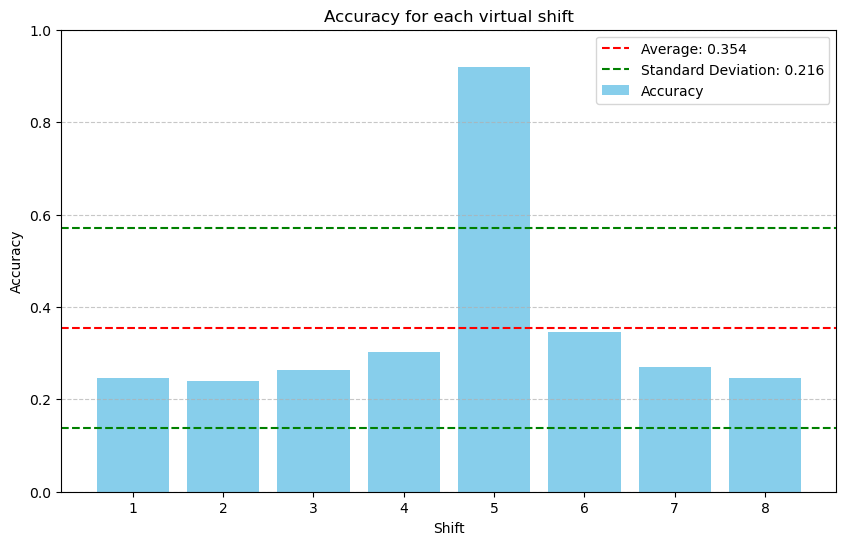

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data

shifts = range(1, len(averages_accuracies_LosReg_list) + 1)

# Calculate average and standard deviation
avg_accuracy = np.mean(averages_accuracies_LosReg_list)
std_deviation = np.std(averages_accuracies_LosReg_list)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(shifts, averages_accuracies_LosReg_list, color='skyblue', label='Accuracy')

# Plot average and standard deviation
plt.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Average: {avg_accuracy:.3f}')
plt.axhline(y=avg_accuracy + std_deviation, color='green', linestyle='--', label=f'Standard Deviation: {std_deviation:.3f}')
plt.axhline(y=avg_accuracy - std_deviation, color='green', linestyle='--')

# Add labels and title
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy for each virtual shift')

# Set y-axis limits
plt.ylim(0 ,1)

# Show legend
plt.legend()

# Show plot
plt.xticks(shifts)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to accumulate predictions and true labels

all_predictions = []
all_true_labels = []
reg = load(f'LogisticRegression_fold_1_shift_0.joblib')  

X_test_shift = roll_data(X_test[0], i)
predictions = reg.predict(X_test_shift)

# Accumulate predictions and true labels
all_predictions.extend(predictions)
all_true_labels.extend(y_test[k_fold])

conf_matrix = confusion_matrix(all_true_labels, all_predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix in shift {shift}')
plt.show()

FFNN

In [22]:
accuracies_FFNN_list = [[] for _ in range(3)] 

for k_fold in range(3):
    modelWOoperator = FFNN(8,9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_shift_0.pt")) # loaded from the file: parameters learned during training.
    modelWOoperator.eval()

    for i in range (-4, 4):
        X_test_shift = roll_data(X_test[k_fold], i)
        test_shift_dataset = CustomSignalData(get_tensor(X_test_shift), get_tensor(y_test[k_fold]))
        testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
        accuracies_FFNN_list[k_fold].append(clf_acc(modelWOoperator, testshiftloader, encoder = None))

for accuracy in accuracies_FFNN_list:
    print(accuracy)

[0.6848565528587419, 0.7231033696812026, 0.6843944109824239, 0.7217908909126204, 0.6874075769161692, 0.7218648304744643, 0.6886276265188139, 0.722308486700058]
[0.7366666692495346, 0.7170833349227905, 0.7229166668653488, 0.7329166686534881, 0.7341666665673255, 0.7191666689515114, 0.7158333337306977, 0.7350000005960464]
[0.7020833349227905, 0.6700000029802322, 0.7066666692495346, 0.6658333331346512, 0.7037499985098838, 0.6737499997019768, 0.7099999991059304, 0.6637500005960465]


In [23]:
averages_accuracies_FFNN_list = [sum(values) / len(values) for values in zip(*accuracies_FFNN_list)]
print(averages_accuracies_FFNN_list)

[0.707868852343689, 0.7033955691947419, 0.7046592490324358, 0.7068469642335865, 0.7084414139977929, 0.7049271663759842, 0.7048203197851474, 0.7070194959640502]


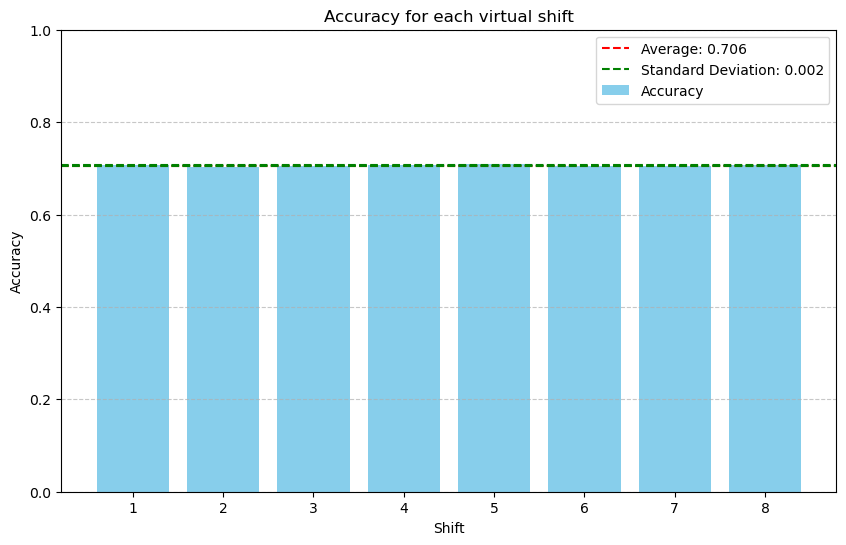

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data

shifts = range(1, len(averages_accuracies_FFNN_list) + 1)

# Calculate average and standard deviation
avg_accuracy = np.mean(averages_accuracies_FFNN_list)
std_deviation = np.std(averages_accuracies_FFNN_list)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(shifts, averages_accuracies_FFNN_list, color='skyblue', label='Accuracy')

# Plot average and standard deviation
plt.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Average: {avg_accuracy:.3f}')
plt.axhline(y=avg_accuracy + std_deviation, color='green', linestyle='--', label=f'Standard Deviation: {std_deviation:.3f}')
plt.axhline(y=avg_accuracy - std_deviation, color='green', linestyle='--')

# Add labels and title
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy for each virtual shift')

# Set y-axis limits
plt.ylim(0 ,1)

# Show legend
plt.legend()

# Show plot
plt.xticks(shifts)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.show()

Self-supervised Learning

In [25]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list = [[] for _ in range(3)] 

for k_fold in range(3):
    classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(8,8)
    encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_shift_0.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_shift_0.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_shift_0.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    for i in range (-4, 4):
        X_test_shift = roll_data(X_test[k_fold], i)
        y1 = encoder(get_tensor(X_test_shift))
        y_tr_rotated = torch.zeros(X_test_shift.shape[0])
        for j, y_ in enumerate(y1):
            distances = np.zeros(8)
            for d in (range(-4,4)):
                x_rotated = used_bases[d].matmul(y_).repeat(N_points,1)
                distances[d] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
            y_tr_rotated[j] = distances.argmin()
        y_tr_est1 = rotate_batch(y1, y_tr_rotated.int(),6)
        y_tr1 = classifier(y_tr_est1).argmax(1)

        accuracies_self_supervised_list[k_fold].append((1-torch.abs(torch.sign(y_tr1- get_tensor(y_test[k_fold]).flatten()))).mean().item())

print(accuracies_self_supervised_list)

[[0.9651212096214294, 0.9663972854614258, 0.9651212096214294, 0.9655465483665466, 0.966822624206543, 0.9659719467163086, 0.9659719467163086, 0.9642705321311951], [0.9554059505462646, 0.9558266997337341, 0.9554059505462646, 0.9549852609634399, 0.9558266997337341, 0.9558266997337341, 0.9558266997337341, 0.9554059505462646], [0.9348739385604858, 0.9357143044471741, 0.9365546107292175, 0.9357143044471741, 0.9336134195327759, 0.9344537854194641, 0.9336134195327759, 0.9336134195327759]]


In [26]:
averages_accuracies_self_supervised_list = [sum(values) / len(values) for values in zip(*accuracies_self_supervised_list)]
print(averages_accuracies_self_supervised_list)

[0.9518003662427267, 0.9526460965474447, 0.9523605902989706, 0.9520820379257202, 0.9520875811576843, 0.9520841439565023, 0.9518040219942728, 0.9510966340700785]


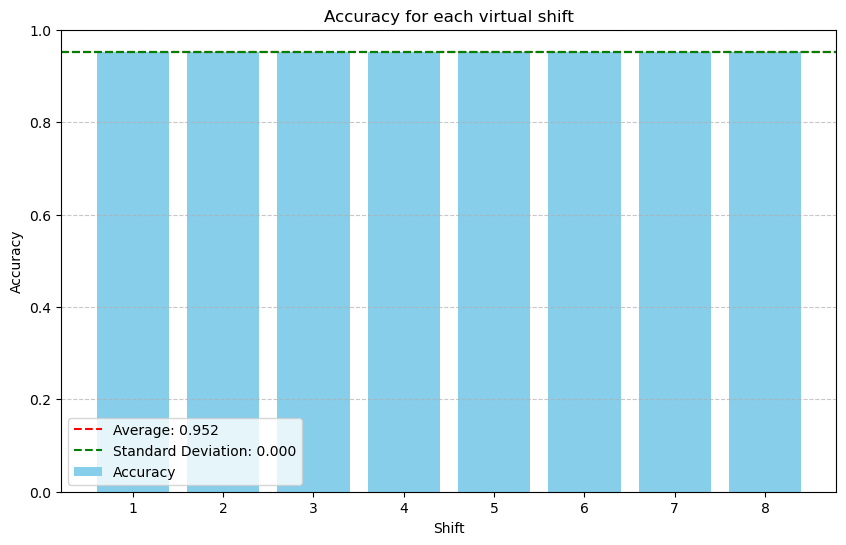

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data

shifts = range(1, len(averages_accuracies_self_supervised_list) + 1)

# Calculate average and standard deviation
avg_accuracy = np.mean(averages_accuracies_self_supervised_list)
std_deviation = np.std(averages_accuracies_self_supervised_list)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(shifts, averages_accuracies_self_supervised_list, color='skyblue', label='Accuracy')

# Plot average and standard deviation
plt.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Average: {avg_accuracy:.3f}')
plt.axhline(y=avg_accuracy + std_deviation, color='green', linestyle='--', label=f'Standard Deviation: {std_deviation:.3f}')
plt.axhline(y=avg_accuracy - std_deviation, color='green', linestyle='--')

# Add labels and title
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy for each virtual shift')

# Set y-axis limits
plt.ylim(0 ,1)

# Show legend
plt.legend()

# Show plot
plt.xticks(shifts)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.show()

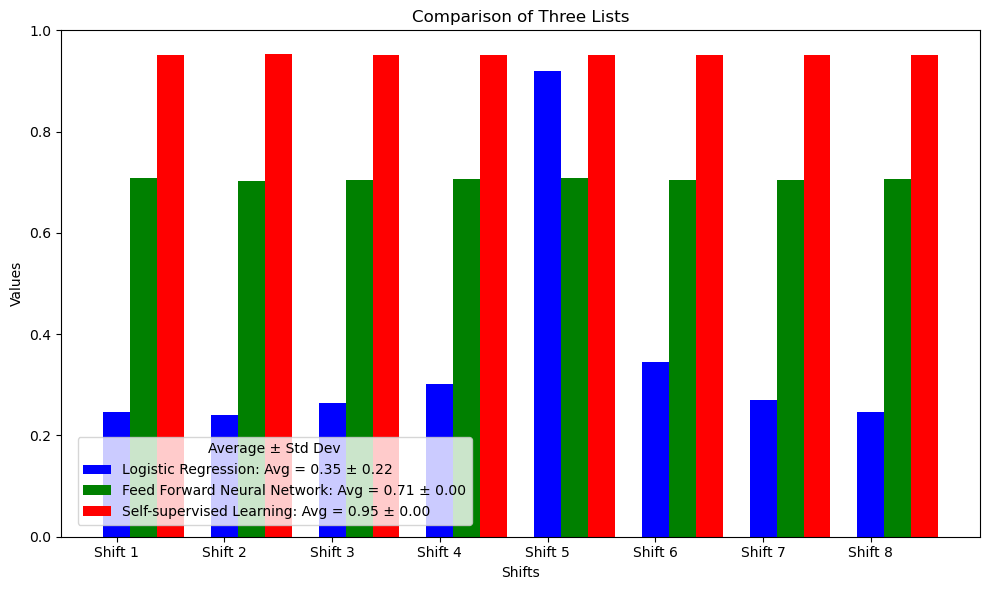

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
list1 = [0.2455150997399246, 0.23986515263396888, 0.26452112019701546, 0.30200419420285013, 0.9199189803370942, 0.3448969166264895, 0.2694817632263427, 0.24622122973090718]
list2 = [0.707868852343689, 0.7033955691947419, 0.7046592490324358, 0.7068469642335865, 0.7084414139977929, 0.7049271663759842, 0.7048203197851474, 0.7070194959640502]
list3 = [0.9518003662427267, 0.9526460965474447, 0.9523605902989706, 0.9520820379257202, 0.9520875811576843, 0.9520841439565023, 0.9518040219942728, 0.9510966340700785]

# Calculate average and standard deviation for each list
average_list1 = np.mean(list1)
std_dev_list1 = np.std(list1)

average_list2 = np.mean(list2)
std_dev_list2 = np.std(list2)

average_list3 = np.mean(list3)
std_dev_list3 = np.std(list3)

# X axis labels
x_labels = ['Shift 1', 'Shift 2', 'Shift 3', 'Shift 4', 'Shift 5', 'Shift 6', 'Shift 7', 'Shift 8']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size of the graph
ax.bar(x_labels, list1, color='b', width=0.25, label='List 1')
ax.bar([x + 0.25 for x in range(len(x_labels))], list2, color='g', width=0.25, label='List 2')
ax.bar([x + 0.5 for x in range(len(x_labels))], list3, color='r', width=0.25, label='List 3')

# Adding labels and title
ax.set_xlabel('Shifts')
ax.set_ylabel('Values')
ax.set_title('Comparison of Three Lists')

# Add average and standard deviation to the legend
legend_labels = [
    f'Logistic Regression: Avg = {average_list1:.2f} ± {std_dev_list1:.2f}',
    f'Feed Forward Neural Network: Avg = {average_list2:.2f} ± {std_dev_list2:.2f}',
    f'Self-supervised Learning: Avg = {average_list3:.2f} ± {std_dev_list3:.2f}'
]
ax.legend(legend_labels, loc='lower left', bbox_to_anchor=(0.01, 0.01), title="Average ± Std Dev")

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
